# Homework - Maze

The homework is very similar to the actual course we had. The difference comes from how to create the maze and how to estimate the score. We have to make a score greater if the "ghost" find the exit fast and the score greater if it is near the exit. When it touch a wall, the score decrease significantly.

The mutation rate is also greater in order to make it explore places that it had never explored.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib

In [2]:
#clear field
def clear():
    """g *= 0
    L = len(g)
    for a in range(L):
        g[a,0] = 2
        g[a,L-1] = 2
        g[0,a] = 2
        g[L-1,a] = 2"""

    g = np.array([[2,2,2,2,2,2,2,2,2,2],
                  [2,0,0,2,0,0,0,2,0,2],
                  [2,0,0,2,0,2,0,0,0,2],
                  [2,0,0,0,0,2,2,2,0,2],
                  [2,0,2,0,0,0,0,0,0,2],
                  [2,0,2,0,2,2,2,2,0,2],
                  [2,0,0,0,0,0,0,0,0,2],
                  [2,0,2,2,2,2,2,2,2,2],
                  [2,0,0,0,0,0,0,0,0,2],
                  [2,0,2,2,2,2,2,2,0,2],
                  [2,0,2,0,0,0,0,0,0,2],
                  [2,0,2,0,2,2,2,2,0,2],
                  [2,0,0,0,0,0,0,0,0,2],
                  [2,2,2,2,2,2,2,2,2,2]])
    return g

In [3]:
#global variable for exit
C = 1
#global array for the direction
d = np.array([[0,1], [-1,0], [0,-1], [1,0]]) # up, left, down, right

In [4]:
#add a exit to a random empty space
def add_exit(g):
    zero = np.where(g==0)
    r = np.random.randint(len(zero[0]))
    #g[zero[0][r]][zero[1][r]] = C
    g[g.shape[0]-2,g.shape[1]-2] = C
    return g

In [5]:
#add ghost to the field array g=3 -> head, g=4 -> rest of the ghost (only used in visualization)
def add_ghost(g,ghost):
    g[ghost[0][0],ghost[0][1]] = 3
    return g

In [6]:
#return what is ahead
def check_head(g, ghost, ir):
    head = np.array(ghost[0])
    head += d[ir]
    return g[head[0]][head[1]]

In [7]:
#mode ghost, if it had eaten a exit then make it longer
def move_ghost(g, ghost, ir, exit):
    head = np.array(ghost[0])

    g[head[0],head[1]] = 0
    new_pos = head + d[ir]
    ghost = [list(new_pos)]
    #print(ghost)
    g[new_pos[0],new_pos[1]] = 4 
    
    return g, ghost

In [8]:
#generate the input for th NN based on the current position. it returns an array of length 8
def get_input(g,ghost):
    exit = np.where(g == C)
    #print(exit)
    #print(len(exit))
    while len(exit[0]) < 1 :
      g = add_exit(g)
      exit = np.where(g == C)

    c = np.array([exit[0][0],exit[1][0]])
    data = np.zeros(8,dtype=int)
    #first four is wether we can go in that direction
    for i in range(4):
        data[i] = check_head(g,ghost,i) < 2
    #next four if the exit is in that direction
    head = np.array(ghost[0])
    for i in range(4):
        data[4 + i] = np.dot(d[i],c - head) > 0
    return(data)

In [9]:
#feedforward which is just a multiplication, since we have only a sinle layer
def get_output(W,X):
    return np.exp(np.dot(X,W))
#This is for multilayer including sigmoid.
    #return 1.0 / (1.0 + np.exp(np.dot(X,W)))

In [10]:
#given the weights makes a full run of the ghost up to muxstep number of steps. Saves the game in the list save
#Algorithm
# 1. check what is ahead
#   - wall or ghost -> die -> score -= 5 and return
#   - exit add +10 to score
# 2. move ghost and go to 1.
def full_run(pos,W,maxstep,save):
  ghost = [[1,8]]
  g = clear()
  g = add_ghost(g,ghost)
  g = add_exit(g)
  score = 0
  save.append(np.copy(g))
  for i in range(maxstep):
    res = get_output(W,get_input(g,ghost))
    nd = res.argmax()
    #print(nd)
    ahead = check_head(g, ghost, nd)
    exit = 0
    if ahead == C: # C is exit
      score += 50000000000 / (i+1) 
      exit = 1
    elif ahead >= 2:
      #print("dead"+str(i))
      score -= 20
      return score + min(10, int(i / 5))

    
    where_exit = np.where(g == C)

    while len(where_exit[0]) < 1 :
      g = add_exit(g)
      where_exit = np.where(g == C)

    c = np.array([where_exit[0][0],where_exit[1][0]])

    dist = np.linalg.norm(c-np.array(ghost[0]))
    
    score += 500/(dist+1)
    g, ghost = move_ghost(g,ghost,nd,exit)
    if exit:
      #print("exit__"+str(i))
      return(score + min(10, int(i / 5)))
      g = add_exit(g)
    save.append(np.copy(g))
  return(score + min(10, int(i / 5)))

In [11]:
#This does not work in function. Can anyone tell me why???
def anim_ghost(save):
  fig = plt.figure()
  ims = []
  for s in save:
      im = plt.imshow(s, animated=True)
      ims.append([im])
  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
  plt.show()
  return ims

In [12]:
W = np.random.normal(0,1.0,(8,4))
save = []
score = full_run(2,W,1000, save)
print(score, len(save))

-20 1


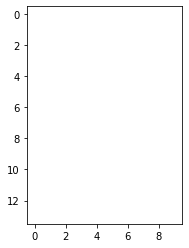

In [13]:
#animate ghost (since function does not work)
fig = plt.figure()
ims = []
for s in save:
    im = plt.imshow(s, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
#plt.show()

In [14]:
rc('animation', html='jshtml')
ani

### Genetic Learning

In [15]:
import pandas as pd

In [16]:
def keep_good_ghost(scores, genes, percentage_to_keep):
  sort = np.argsort(np.array(scores))[::-1]
  ordered_pop = genes[sort]

  nb_to_keep = int(percentage_to_keep*len(scores))

  best_pop = ordered_pop[:nb_to_keep]
  return best_pop

In [17]:
def crossover(best_pop,crossover_rate,population,weigth_shape):

  nb_pop_to_create = (population-len(best_pop))
  parents = np.random.randint(0,len(best_pop),nb_pop_to_create*2)

  crossover_pop = np.zeros((nb_pop_to_create,weigth_shape[0],weigth_shape[1]))

  for i in range(nb_pop_to_create):
    parent_1 = parents[i]
    parent_2 = parents[i+1]

    gene_1 = best_pop[parent_1]
    gene_2 = best_pop[parent_2]

    crossover_matrix = np.random.randint(0,2,(weigth_shape[0],weigth_shape[1]))

    new_gene = gene_1 * crossover_matrix + gene_2 * (1-crossover_matrix)

    crossover_pop[i] = new_gene

  sum_of_pop = np.vstack((best_pop,crossover_pop))
  return sum_of_pop

In [18]:
def mutate(completed_pop,mutation_rate,weigth_shape,population):
  where_mutation = np.random.choice(2, size=(population,weigth_shape[0],weigth_shape[1]), p=[1-mutation_rate,mutation_rate])
  values_of_mutation = np.random.normal(0,1.0,(population,weigth_shape[0],weigth_shape[1]))

  mutations = where_mutation * values_of_mutation
  completed_pop += mutations

  return completed_pop

In [19]:
def genetic(population, weigth_shape, max_loop, percentage_to_keep, crossover_rate, mutation_rate):
  genes = np.random.normal(0,1.0,(population,weigth_shape[0],weigth_shape[1]))
  

  for i in range(max_loop):
    print(f"Generation {i}/{max_loop}")


    scores = []
    saves = []


    for j in range(len(genes)) :

      maxstep = 200
      L = 2

      save = []
      score = full_run(L,genes[j],maxstep,save)
      scores.append(score)
      saves.append(save)

    #print(scores)

    best_pop = keep_good_ghost(scores, genes, percentage_to_keep)
    completed_pop = crossover(best_pop,crossover_rate,population,weigth_shape)
    new_pop = mutate(completed_pop,mutation_rate,weigth_shape,population)

    genes = new_pop



  return genes, scores, saves

In [20]:
POPULATION = 300
WEIGTH_SHAPE = [8,4]
MAX_LOOP = 300

PERCENTAGE_TO_KEEP = 0.5
CROSSOVER_RATE = 0.5

MUTATION_RATE = 0.05

In [21]:
genes, scores, saves = genetic(POPULATION, WEIGTH_SHAPE, MAX_LOOP, PERCENTAGE_TO_KEEP, CROSSOVER_RATE, MUTATION_RATE)

Generation 0/300
Generation 1/300
Generation 2/300
Generation 3/300
Generation 4/300
Generation 5/300
Generation 6/300
Generation 7/300
Generation 8/300
Generation 9/300
Generation 10/300
Generation 11/300
Generation 12/300
Generation 13/300
Generation 14/300
Generation 15/300
Generation 16/300
Generation 17/300
Generation 18/300
Generation 19/300
Generation 20/300
Generation 21/300
Generation 22/300
Generation 23/300
Generation 24/300
Generation 25/300
Generation 26/300
Generation 27/300
Generation 28/300
Generation 29/300
Generation 30/300
Generation 31/300
Generation 32/300
Generation 33/300
Generation 34/300
Generation 35/300
Generation 36/300
Generation 37/300
Generation 38/300
Generation 39/300
Generation 40/300
Generation 41/300
Generation 42/300
Generation 43/300
Generation 44/300
Generation 45/300
Generation 46/300
Generation 47/300
Generation 48/300
Generation 49/300
Generation 50/300
Generation 51/300
Generation 52/300
Generation 53/300
Generation 54/300
Generation 55/300
Ge

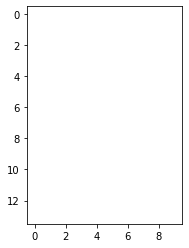

In [22]:
#animate ghost (since function does not work)
fig = plt.figure()
ims = []
for s in saves[0]:
    im = plt.imshow(s, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
#plt.show()

In [23]:
rc('animation', html='jshtml')
ani